# Gradient boosting classification of high entropy alloys

## Setup

In [3]:
# Notebook settings

# code development settings (automatically reload modified modules)
%load_ext autoreload
%autoreload 2

# plotting backend
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# basic libraries
import os
from itertools import combinations

# ML
import numpy as np
from scipy.stats import uniform, randint
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split, cross_val_predict

# plotting
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib
import seaborn as sns

In [5]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb

In [6]:
# project directories
data_raw = '../data/raw'
data_interim = '../data/interim'
data_processed = '../data/processed'
reports_dir = '../reports'
src_dir = '../src'

## Read data

In [7]:
# import CSV (which was exported from Excel), in need for a serious cleanup
df_xy = pd.read_csv(os.path.join(data_interim, 'alloys_model_ready.csv'))

In [8]:
df_xy.lattice = df_xy.lattice.astype('category')
df_xy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 8 columns):
density    355 non-null float64
DH_mix     355 non-null float64
DS_mix     355 non-null float64
T_m        355 non-null float64
delta      355 non-null float64
D_elneg    355 non-null float64
VEC        355 non-null float64
lattice    355 non-null category
dtypes: category(1), float64(7)
memory usage: 20.0 KB


In [9]:
df_xy.head()

,density,DH_mix,DS_mix,T_m,delta,D_elneg,VEC,lattice
0,14.88,-6.0,5.76,1286.13,0.35,0.31,11.0,FCC
1,8.37,-1.0,5.76,1789.50,0.79,0.03,8.5,FCC
2,8.90,0.0,5.76,1748.00,0.00,0.02,9.5,FCC
3,8.91,4.0,5.76,1542.88,1.19,0.01,10.5,FCC
4,8.37,-2.0,5.76,1769.50,0.79,0.04,9.0,FCC


## Prepare data for simple modeling

In [10]:
cols = list(df_xy.columns)
cols.remove('lattice')

In [11]:
X = df_xy[cols].values
y = df_xy['lattice'].cat.codes.values

In [168]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3,

In [210]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)#shuffle=True)#, random_state=42)

**Gradient boosting machine vs Logistic regression**

In [221]:
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('Accuracy on the training data:', xgb_model.score(X_train, y_train))
print('Accuracy on the testing data:', xgb_model.score(X_test, y_test))

[[ 5  0  0  0  3]
 [ 0  3  0  0  2]
 [ 0  1  2  0  0]
 [ 0  0  0 12  0]
 [ 0  1  0  0 42]]
Accuracy on the training data: 1.0
Accuracy on the testing data: 0.9014084507042254


In [222]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [212]:
#lreg = LogisticRegression(C=1.088534267260644, multi_class='multinomial', solver='lbfgs', warm_start=True, max_iter=10000)
lreg = LogisticRegression(C=0.55, multi_class='multinomial', solver='lbfgs', warm_start=True, max_iter=10000)
lreg.fit(X_train, y_train)
y_pred = lreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('Accuracy on the training data:', lreg.score(X_train, y_train))
print('Accuracy on the testing data:', lreg.score(X_test, y_test))

[[ 7  0  0  0  1]
 [ 0  2  0  0  3]
 [ 0  1  2  0  0]
 [ 0  0  0 11  1]
 [ 1  1  0  0 41]]
Accuracy on the training data: 0.9647887323943662
Accuracy on the testing data: 0.8873239436619719


In [213]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [214]:
def return_best_parameters(results, n_top=3):
    """ Find n_top best hyparameters
    """
    
    tot_error = (1-results['mean_test_score'])**2 #+ results['std_test_score']
    max_error = np.max(tot_error)
    #results['tot_error'] = tot_error    

    params = []
    for i in range(1, n_top + 1):
        j = np.argmin(tot_error)
        
        print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                  results['mean_test_score'][j],
                  results['std_test_score'][j]))
        print("Parameters: {0}".format(results['params'][j]))
        print("")

        params.append(results['params'][j])
        tot_error[j] = max_error

    return params

In [223]:
xgb_model2 = xgb.XGBClassifier()

params = {
    #"colsample_bytree": uniform(0.7, 0.3),
    #"gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    #"subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model2, param_distributions=params, random_state=42, n_iter=200, cv=4, verbose=1, n_jobs=-4, return_train_score=True)

search.fit(X_train, y_train)

report_best_scores(search.cv_results_, 1)

Fitting 4 folds for each of 200 candidates, totalling 800 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-4)]: Done 342 tasks      | elapsed:    6.4s


Model with rank: 1
Mean validation score: 0.9296 (std: 0.0179)
Parameters: {'learning_rate': 0.14236203565420874, 'max_depth': 2, 'n_estimators': 114}

Model with rank: 1
Mean validation score: 0.9296 (std: 0.0195)
Parameters: {'learning_rate': 0.08200939605233162, 'max_depth': 2, 'n_estimators': 135}

Model with rank: 1
Mean validation score: 0.9296 (std: 0.0195)
Parameters: {'learning_rate': 0.08879485872574355, 'max_depth': 2, 'n_estimators': 139}

Model with rank: 1
Mean validation score: 0.9296 (std: 0.0195)
Parameters: {'learning_rate': 0.09091836742043082, 'max_depth': 2, 'n_estimators': 131}

Model with rank: 1
Mean validation score: 0.9296 (std: 0.0172)
Parameters: {'learning_rate': 0.0872733093451038, 'max_depth': 2, 'n_estimators': 102}

Model with rank: 1
Mean validation score: 0.9296 (std: 0.0195)
Parameters: {'learning_rate': 0.08084782400582774, 'max_depth': 2, 'n_estimators': 141}

Model with rank: 1
Mean validation score: 0.9296 (std: 0.0195)
Parameters: {'learning_rat

[Parallel(n_jobs=-4)]: Done 800 out of 800 | elapsed:   12.7s finished
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [224]:
search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.14236203565420874,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=114, n_jobs=1, nthread=None,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [225]:
best_params2 = return_best_parameters(search.cv_results_, 5)

Mean validation score: 0.9296 (std: 0.0179)
Parameters: {'learning_rate': 0.14236203565420874, 'max_depth': 2, 'n_estimators': 114}

Mean validation score: 0.9296 (std: 0.0195)
Parameters: {'learning_rate': 0.08200939605233162, 'max_depth': 2, 'n_estimators': 135}

Mean validation score: 0.9296 (std: 0.0195)
Parameters: {'learning_rate': 0.08879485872574355, 'max_depth': 2, 'n_estimators': 139}

Mean validation score: 0.9296 (std: 0.0195)
Parameters: {'learning_rate': 0.09091836742043082, 'max_depth': 2, 'n_estimators': 131}

Mean validation score: 0.9296 (std: 0.0172)
Parameters: {'learning_rate': 0.0872733093451038, 'max_depth': 2, 'n_estimators': 102}



In [226]:
search.cv_results_['split0_test_score']#.keys()

array([0.91780822, 0.90410959, 0.87671233, 0.89041096, 0.90410959,
       0.89041096, 0.89041096, 0.89041096, 0.90410959, 0.89041096,
       0.89041096, 0.89041096, 0.87671233, 0.91780822, 0.89041096,
       0.89041096, 0.89041096, 0.89041096, 0.89041096, 0.90410959,
       0.87671233, 0.89041096, 0.90410959, 0.89041096, 0.89041096,
       0.89041096, 0.90410959, 0.90410959, 0.89041096, 0.90410959,
       0.89041096, 0.90410959, 0.89041096, 0.89041096, 0.89041096,
       0.89041096, 0.89041096, 0.90410959, 0.89041096, 0.90410959,
       0.89041096, 0.89041096, 0.89041096, 0.89041096, 0.90410959,
       0.89041096, 0.87671233, 0.90410959, 0.90410959, 0.87671233,
       0.90410959, 0.89041096, 0.89041096, 0.90410959, 0.89041096,
       0.89041096, 0.89041096, 0.89041096, 0.90410959, 0.90410959,
       0.90410959, 0.89041096, 0.87671233, 0.90410959, 0.89041096,
       0.89041096, 0.90410959, 0.89041096, 0.89041096, 0.90410959,
       0.90410959, 0.89041096, 0.89041096, 0.90410959, 0.89041

In [227]:
#xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42, **best_params2[0])
#xgb_model2.set_params(**best_params2[0])
#xgb_model2.fit(X_train, y_train)
xgb_modelx = search.best_estimator_
y_pred = xgb_modelx.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('Accuracy on the training data:', xgb_modelx.score(X_train, y_train))
print('Accuracy on the testing data:', xgb_modelx.score(X_test, y_test))

[[ 5  0  0  0  3]
 [ 0  3  0  0  2]
 [ 0  1  2  0  0]
 [ 0  0  0 12  0]
 [ 0  1  0  0 42]]
Accuracy on the training data: 1.0
Accuracy on the testing data: 0.9014084507042254


In [203]:
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [204]:
y_pred = search.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy on the training data:', search.score(X_train, y_train))
print('Accuracy on the testing data:', search.score(X_test, y_test))

[[ 7  0  1  0  0]
 [ 0  3  0  0  2]
 [ 0  0  3  0  0]
 [ 0  0  0 11  1]
 [ 2  1  0  0 40]]
Accuracy on the training data: 1.0
Accuracy on the testing data: 0.9014084507042254


In [205]:
param_grid_lreg = {
        'C':list(np.logspace(-0.3, 0.2, 25)),
        #'penalty':['l1','l2']
}
grid_lreg = GridSearchCV(lreg, param_grid=param_grid_lreg, cv=5, n_jobs=4)

grid_lreg.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=0.55, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=True),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'C': [0.5011872336272722, 0.5258154385342929, 0.5516538667595581, 0.5787619883491206, 0.6072021956909885, 0.6370399471182163, 0.6683439175686147, 0.7011861566478365, 0.7356422544596414, 0.7717915155850125, 0.809717141610562, 0.849506422626332, 0.8912509381337456, 0.9350467678261198, 0.98...5, 1.308177474260194, 1.372460961007562, 1.439903320881633, 1.5106597800522295, 1.5848931924611136]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [206]:
y_pred = grid_lreg.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[ 8  0  0  0  0]
 [ 0  2  0  0  3]
 [ 0  0  3  0  0]
 [ 0  0  0 11  1]
 [ 1  1  0  0 41]]


In [207]:
print('Accuracy on the training data:', grid_lreg.score(X_train, y_train))
print('Accuracy on the testing data:', grid_lreg.score(X_test, y_test))

# Identify optimal parameters
mean_scores_lreg = np.array(grid_lreg.cv_results_['mean_test_score']).reshape(25)
print('Maximum score:', mean_scores_lreg.max())

#print(mean_scores)
best_index = np.unravel_index(np.argmax(mean_scores_lreg, axis=None), mean_scores_lreg.shape)
print('Best hyperparameters:')
grid_list_lreg = sorted(param_grid_lreg)
#print(grid_list)
#print(best_index)
for i, j in enumerate(best_index):
    print(' ', grid_list_lreg[i],':', param_grid_lreg[grid_list_lreg[i]][j])

Accuracy on the training data: 0.9471830985915493
Accuracy on the testing data: 0.9154929577464789
Maximum score: 0.926056338028169
Best hyperparameters:
  C : 0.5787619883491206


In [31]:
y_pred = grid_lreg.predict(X)
df_out_lr = df_xy.assign(pred=y_pred)
df_out_lr = df_out_lr.assign(orig=y)

df_out_lr.pred = df_out_lr.pred.astype('category')
df_out_lr.pred = df_out_lr.pred.cat.rename_categories({1:'FCC', 0:'BCC', 2:'HCP', 4:'multi-phase', 3:'amorphous'})

In [32]:
# Compare predictions of LogReg and LDA
plt.style.use('ggplot')

def compare_predictions(xlabel, ylabel):

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)

    sns.scatterplot(x=xlabel, y=ylabel, hue='lattice', data=df_out_lr, ax=axs[0], s=120)
    axs[0].set_title('TARGET', fontsize=30)
    axs[0].set_xlabel(xlabel, fontsize=30)
    axs[0].set_ylabel(ylabel, fontsize=30)
    axs[0].legend(fontsize=20)

    sns.scatterplot(x=xlabel, y=ylabel, hue='pred', data=df_out_lr, ax=axs[1], s=120)
    axs[1].set_title('Method: LogReg', fontsize=30)
    axs[1].set_xlabel(xlabel, fontsize=30)
    axs[1].legend(fontsize=20)

    plt.tight_layout()

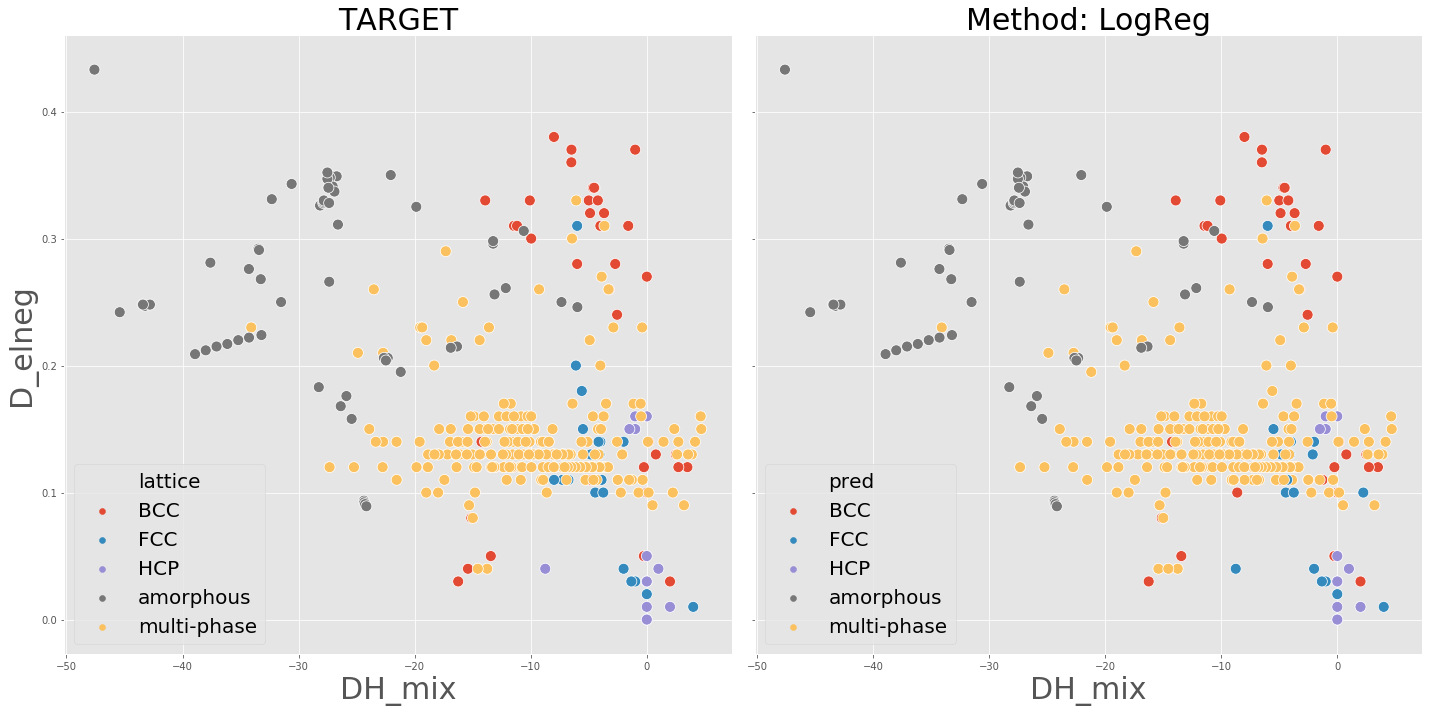

In [33]:
compare_predictions('DH_mix', 'D_elneg')

In [34]:
# cols = ['density', 'DH_mix', 'DS_mix', 'T_m', 'delta', 'D_elneg', 'VEC']
# for x, y in combinations(cols, 2):
#     compare_predictions(x, y)

## Probability space plots

In [35]:
X = df_xy[cols].values
y = df_xy['lattice'].cat.codes.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

In [36]:
data_prob = lreg.predict_proba(X)

In [37]:
grid_lreg.best_estimator_

LogisticRegression(C=0.5011872336272722, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='multinomial', n_jobs=None, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=True)

In [40]:
def plot_ternary(data, size=10):
    
    triplets = list(combinations(range(data.shape[1]), 3))
    
    with plt.style.context(('seaborn-white')):
        size_ax = size
        size_x = size_ax
        size_y = size*0.75**0.5
        
        ncols = 3
        nrows = 1 + (len(triplets)-1)//ncols
        
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size_x*ncols, size_y*nrows))
        
        for ia, (i, j, k) in enumerate(triplets):
            
            ir, ic = divmod(ia, ncols)

            # Make frame (always same)
            frame_x = np.array([0.0, 0.5*size_x/size, size_x/size])
            frame_y = np.array([0.0, size_y/size, 0.0])
            frame_triangle = np.array([[0, 1, 2]])
            frame_triang = tri.Triangulation(frame_x, frame_y, frame_triangle)
            axes[ir, ic].triplot(frame_triang, 'k-')
            axes[ir, ic].plot([frame_x[1], frame_x[1]], [frame_y[1]/3, 0.0], 'k--')
            axes[ir, ic].plot([frame_x[1], frame_x[1]/2], [frame_y[1]/3, frame_y[1]/2], 'k--')
            axes[ir, ic].plot([frame_x[1], (frame_x[1]+frame_x[2])/2], [frame_y[1]/3, (frame_y[1]+frame_y[2])/2], 'k--')
            axes[ir, ic].axis('off')
        
            # translate the data to cartesian coords
            a = data[:, i]
            b = data[:, j]
            c = data[:, k]
            x = 0.5 * ( 2.*b+c ) / ( a+b+c )*1
            y = 0.5*np.sqrt(3) * c / (a+b+c)*1
            axes[ir, ic].plot(x, y, 'ro', label=f'{i}-{j}-{k}')
            axes[ir, ic].legend()

        # erase unused subplots
        for ia in range(len(triplets), nrows*ncols):
            ir, ic = divmod(ia, ncols)
            axes[ir, ic].axis('off')


#         # Make contours
#         profile_triangles = np.array([[0, 1, 4], [1, 2, 5], [2, 3, 6], [1, 5, 4], [2, 6, 5], [4, 5, 7],
#              [5, 6, 8], [5, 8, 7], [7, 8, 9]])

#         profile_triang = tri.Triangulation(profile_x, profile_y, profile_triangle)

#         # Interpolate to regularly-spaced quad grid.
#         z = np.cos(1.5 * x) * np.cos(1.5 * y)
#         xi, yi = np.meshgrid(np.linspace(0, 3, 20), np.linspace(0, 3, 20))

#         interp_lin = tri.LinearTriInterpolator(triang, z)
#         zi_lin = interp_lin(xi, yi)

#         interp_cubic_geom = tri.CubicTriInterpolator(triang, z, kind='geom')
#         zi_cubic_geom = interp_cubic_geom(xi, yi)

#         interp_cubic_min_E = tri.CubicTriInterpolator(triang, z, kind='min_E')
#         zi_cubic_min_E = interp_cubic_min_E(xi, yi)

#         # Plot the triangulation.
#         plt.tricontourf(triang, z, alpha=1/3)

#         # Make data points
#         x = np.asarray([0, 1, 2, 3, 0.5, 1.5, 2.5, 1, 2, 1.5])/3
#         y = np.asarray([0, 0, 0, 0, 1.0, 1.0, 1.0, 2, 2, 3.0])/3
#         print(x)
#         print(y)

# # test_data = np.array([[0,0,1,0],
# #                       [0,1,0,1],
# #                       [1,0,0,2],
# #                       [0.25,0.25,0.5,4],
# #                       [0.25,0.5,0.25,2],
# #                       [0.5,0.25,0.25,0]])

# # # barycentric coords: (a,b,c)
# # a=test_data[:,0]
# # b=test_data[:,1]
# # c=test_data[:,2]

# # # translate the data to cartesian corrds
# # x = 0.5 * ( 2.*b+c ) / ( a+b+c )*1
# # y = 0.5*np.sqrt(3) * c / (a+b+c)*1

# # print('x', x)
# # print('y', y)

#         plt.triplot(x*0.7, y*0.7, 'co')
#         #plt.triplot(x*0.3+1.05, y*0.9+0.2, 'ro')


#         plt.title('Triangular grid')

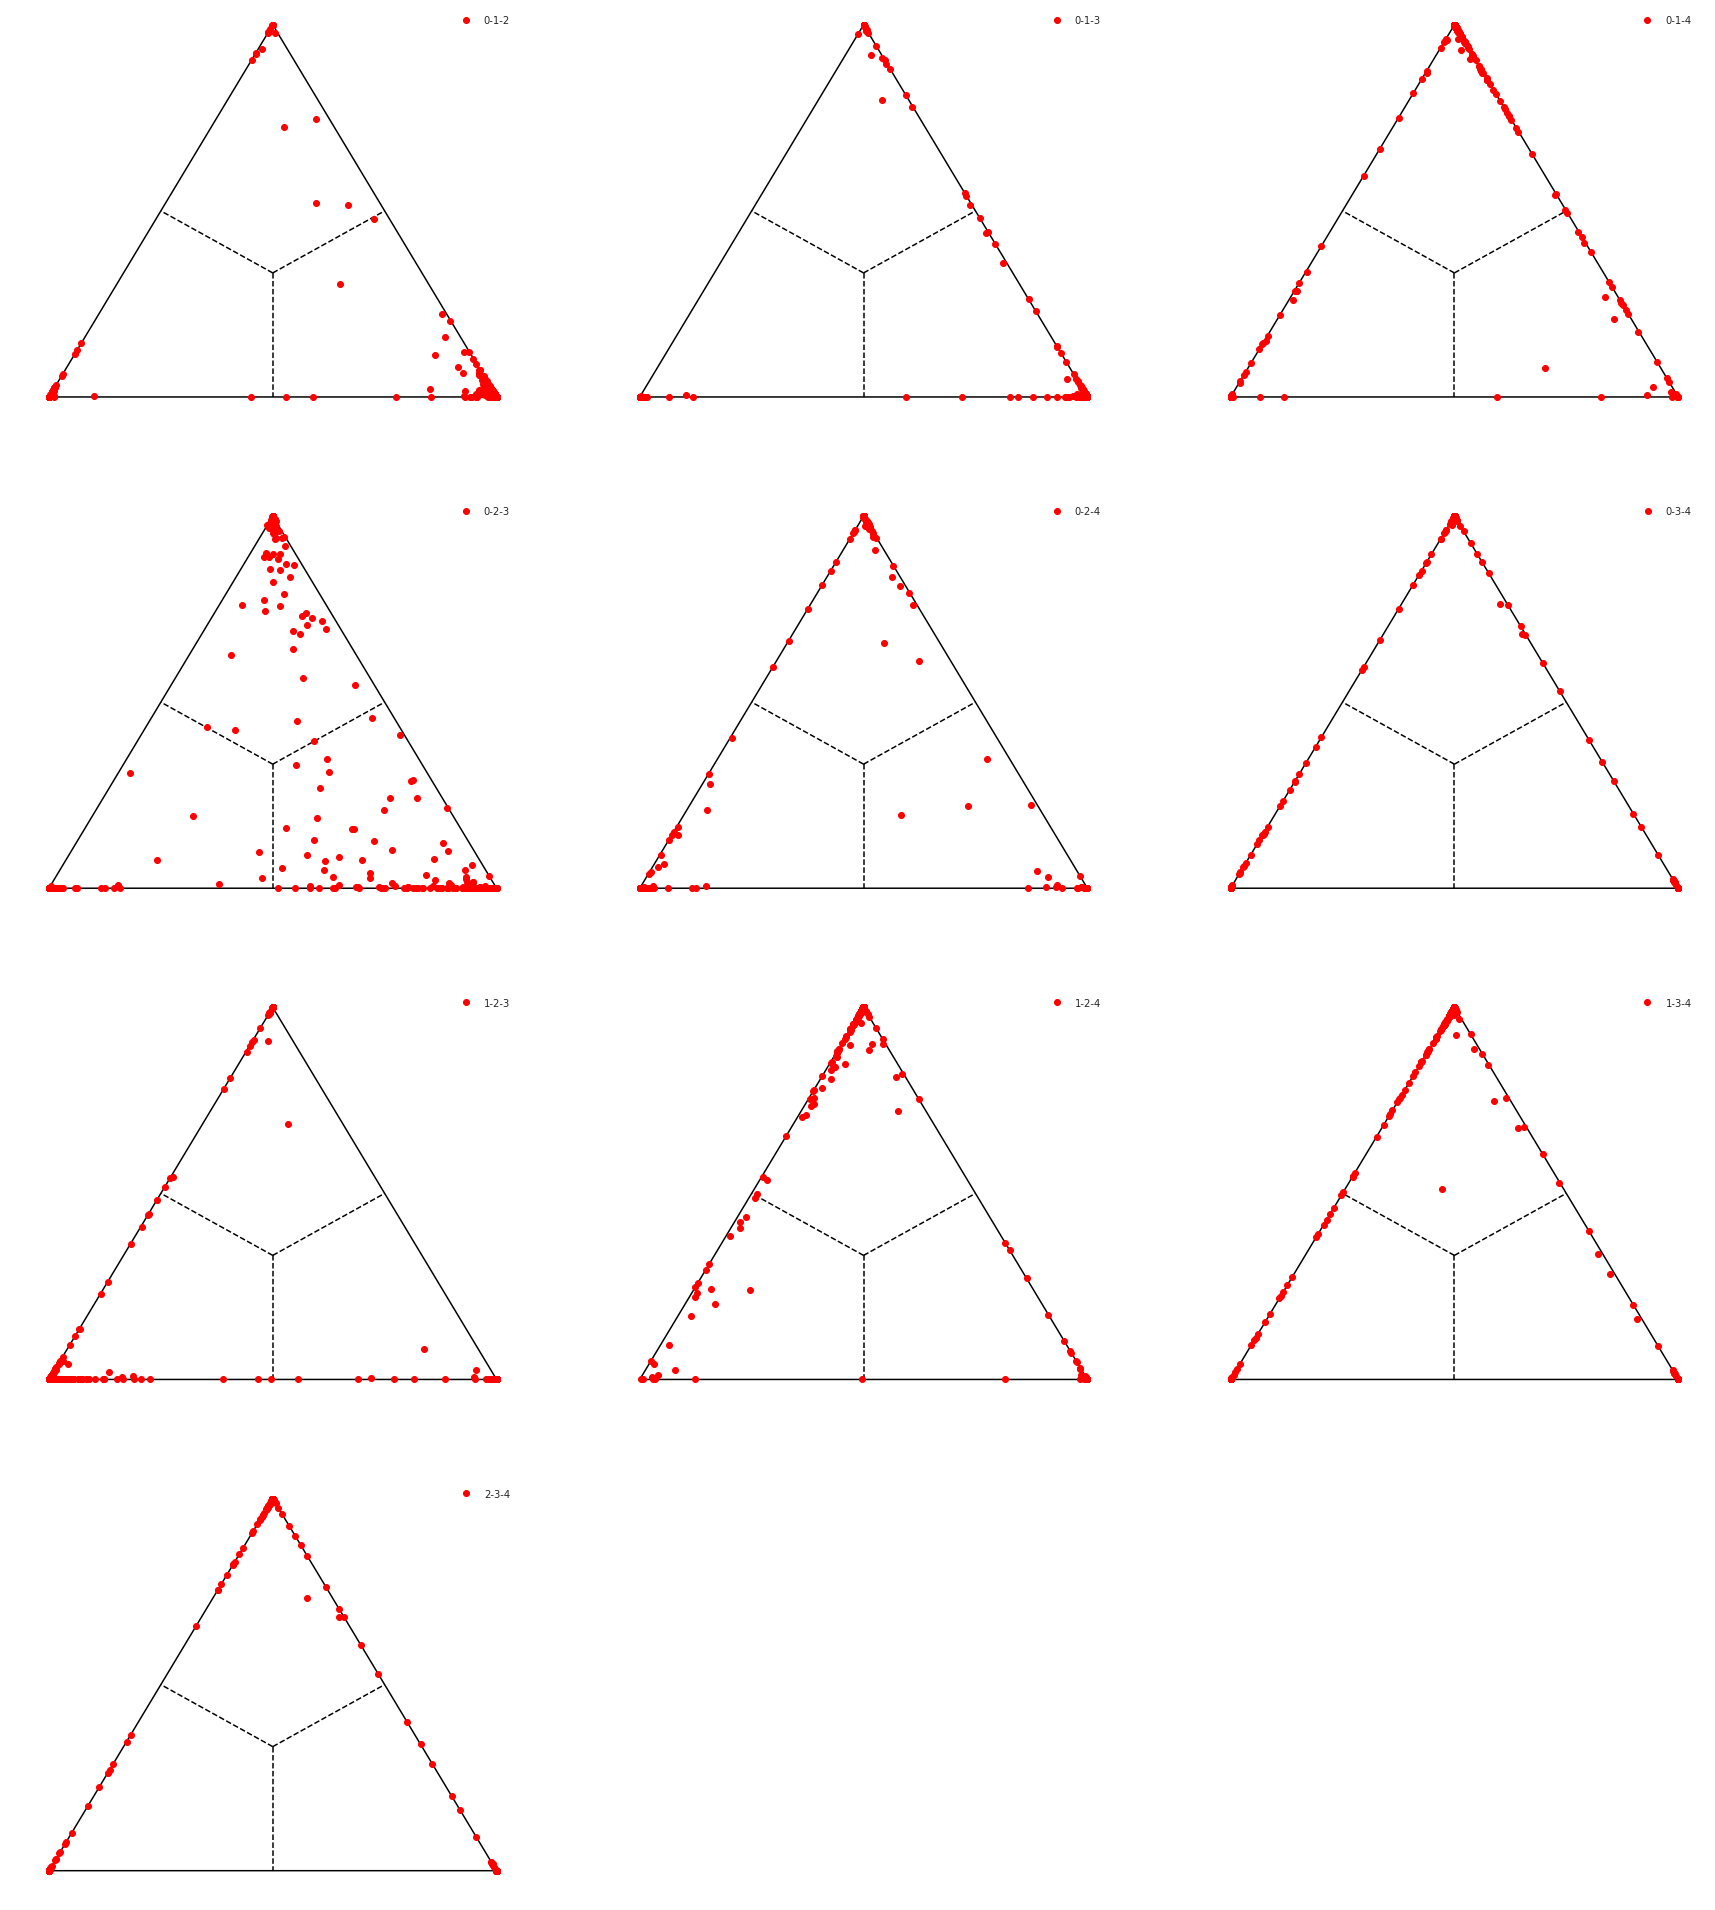

In [41]:
plot_ternary(data_prob, size=10)

[0. 2. 4. 8. 4. 0.]


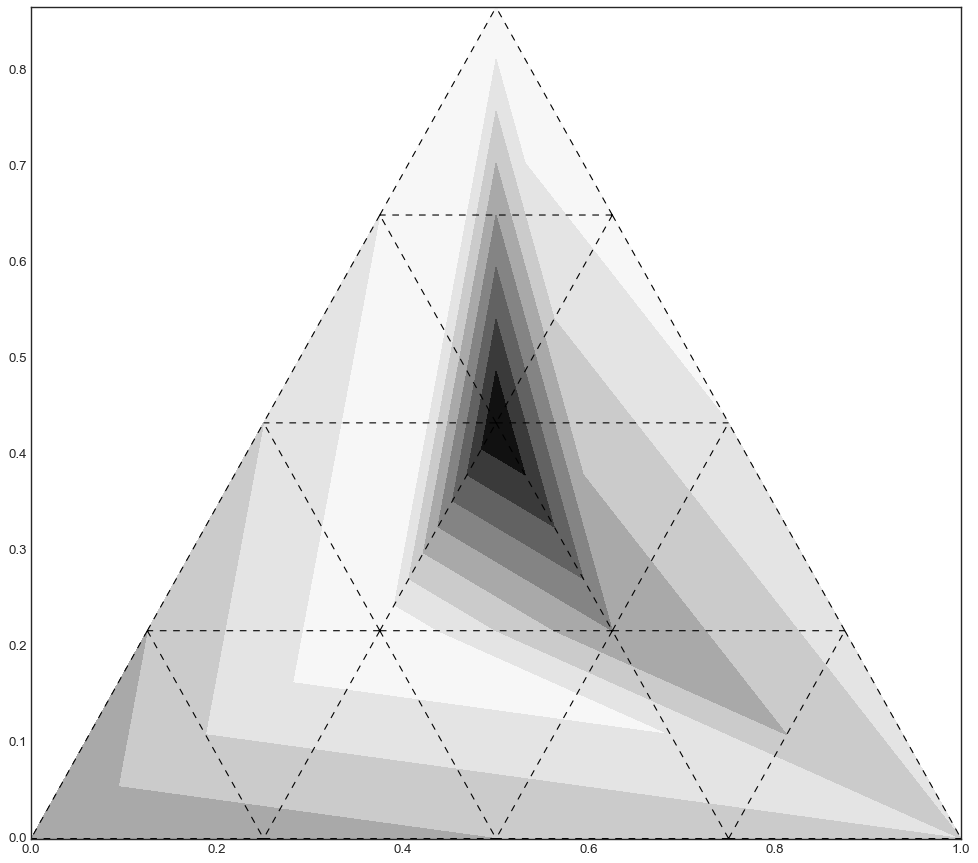

In [135]:
size_x = 15
size_y = size_x*0.75**0.5
plt.figure(figsize=(size_x, size_y))

test_data = np.array([[0,0,1,0],
                      [0,1,0,1],
                      [1,0,0,2],
                      [0.25,0.25,0.5,4],
                      [0.25,0.5,0.25,2],
                      [0.5,0.25,0.25,0]])

# barycentric coords: (a,b,c)
a=test_data[:,0]
b=test_data[:,1]
c=test_data[:,2]

# values is stored in the last column
v = test_data[:,-1]*2

print(v)

# translate the data to cartesian corrds
x = 0.5 * ( 2.*b+c ) / ( a+b+c )
y = 0.5*np.sqrt(3) * c / (a+b+c)


# create a triangulation out of these points
T = tri.Triangulation(x,y)

# plot the contour
#plt.tricontourf(x,y,T.triangles,v)
plt.tricontourf(x,y,T.triangles,v)


# create the grid
corners = np.array([[0, 0], [1, 0], [0.5,  np.sqrt(3)*0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# creating the grid
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=2)

#plotting the mesh
plt.triplot(trimesh,'k--')

plt.show()

In [76]:
lda_dr = LinearDiscriminantAnalysis(n_components=3)
lda_dr.fit(X_train, y_train)
print('Accuracy on the training data:', lda_dr.score(X_train, y_train))
#print('Accuracy on the testing data:', lda_dr.score(X_test, y_test))

Accuracy on the training data: 0.9154929577464789


In [70]:
y_pred = lda_dr.predict(X)
df_out_lda = df_xy.assign(pred=y_pred)
df_out_lda = df_out_lda.assign(orig=y)

df_out_lda.pred = df_out_lda.pred.astype('category')
df_out_lda.pred = df_out_lda.pred.cat.rename_categories({1:'FCC', 0:'BCC', 2:'HCP', 4:'multi-phase', 3:'amorphous'})

In [71]:
X_lda = lda_dr.fit_transform(X, y)

In [81]:
def plot_pairviews(xc, yc): 
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(30,15), sharey=True)

    sns.scatterplot(x=X_lda[:,xc], y=X_lda[:,yc], hue='lattice', data=df_out_lda, ax=axs[0], s=120)
    axs[0].set_title('TARGET (2d-projection)', fontsize=30)
    axs[0].legend(fontsize=20)

    sns.scatterplot(x=X_lda[:,xc], y=X_lda[:,yc], hue='pred', data=df_out_lr, ax=axs[1], s=120)
    axs[1].set_title('Method: LDA (2d-projection)', fontsize=30)
    axs[1].legend(fontsize=20)

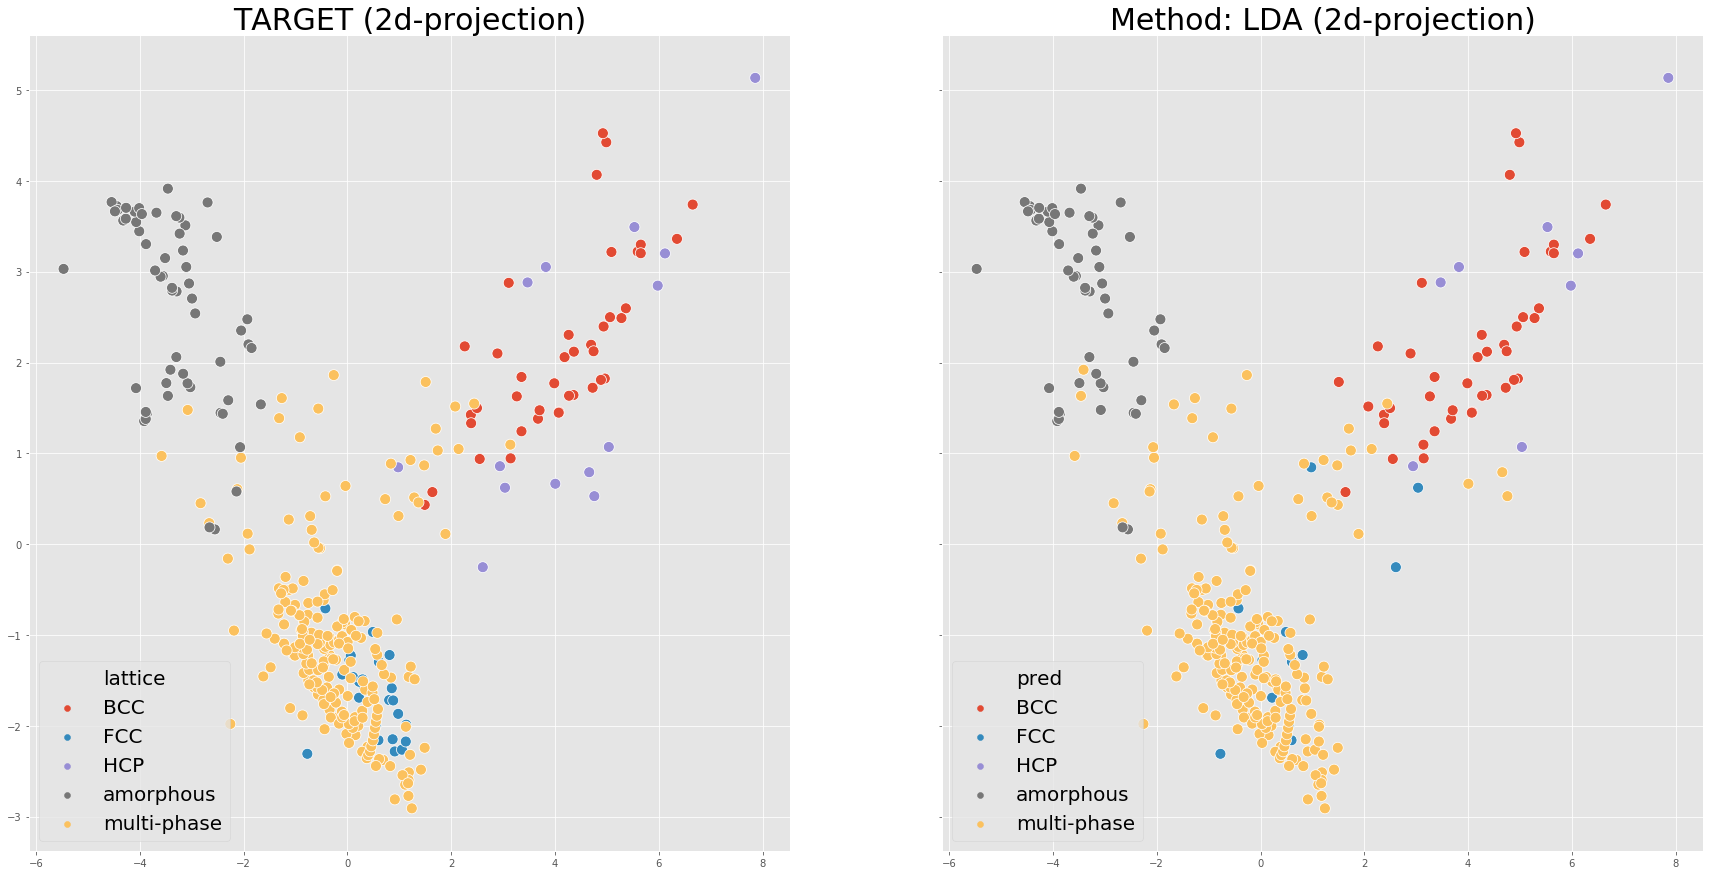

In [82]:
plot_pairviews(0, 1)

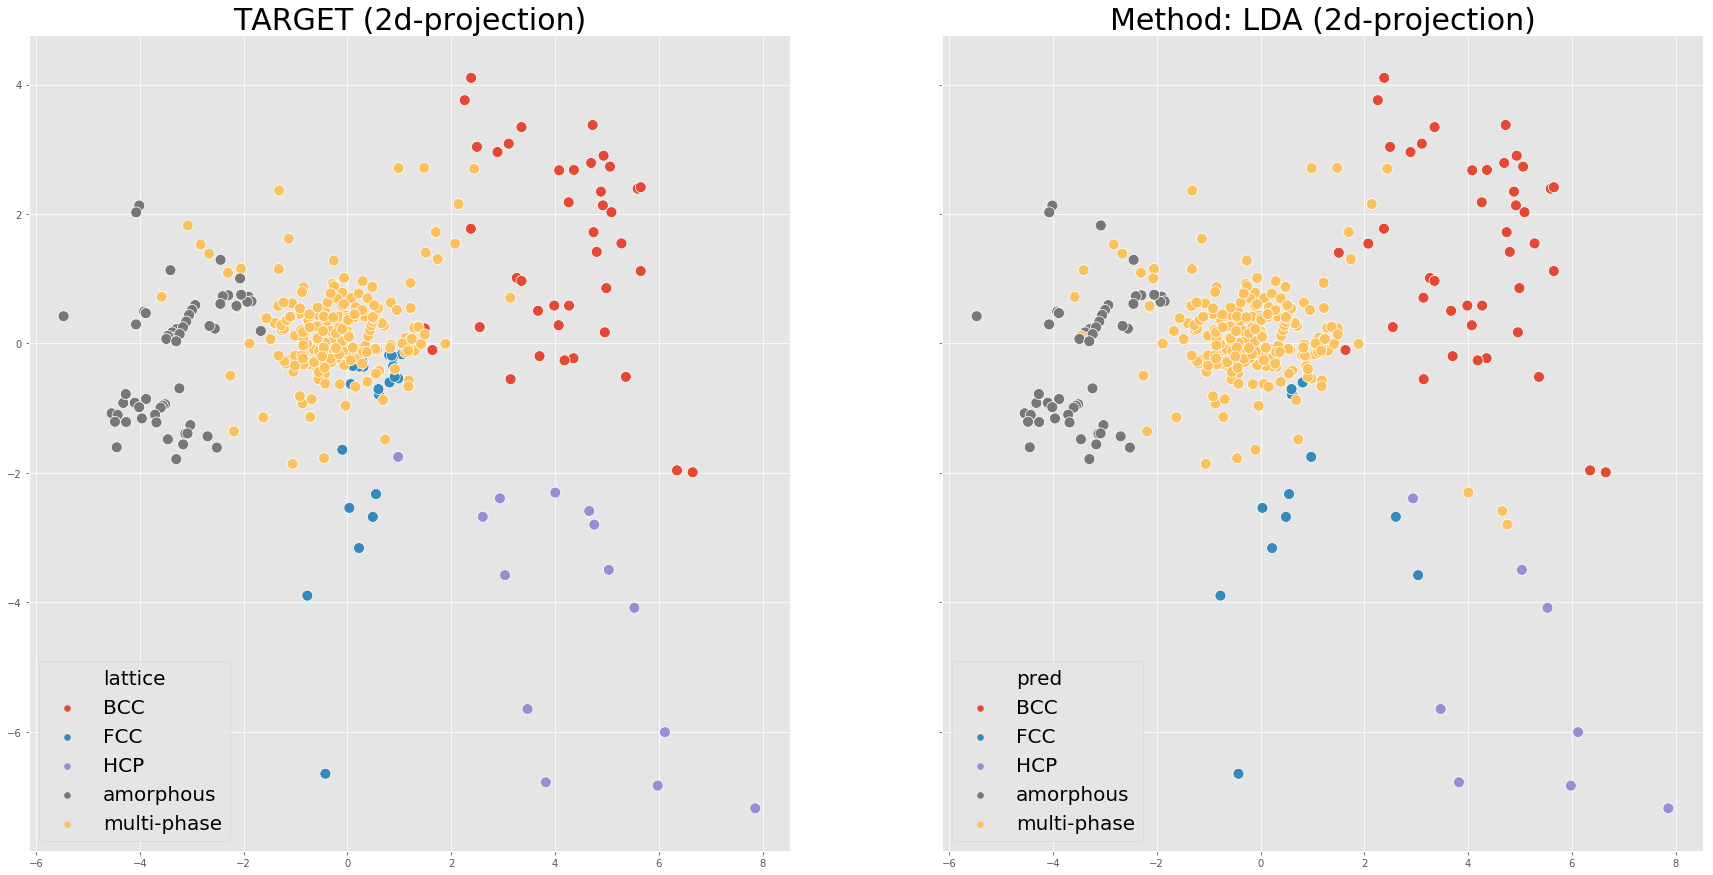

In [83]:
plot_pairviews(0, 2)

In [85]:
#plot_pairviews(1, 2)